In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import IPython
import IPython.display

In [3]:
df=pd.read_csv('/content/drive/MyDrive/CANIDS/Data/normal_run_data.csv')
df['label']='R'

colnames=['Timestamp', 'ID', 'DLC', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8','label'] 
DoS_df=pd.read_csv('/content/drive/MyDrive/CANIDS/Data/DoS_dataset.csv',names=colnames)

In [4]:
df.dtypes

Timestamp    float64
ID            object
DLC            int64
D1            object
D2            object
D3            object
D4            object
D5            object
D6            object
D7            object
D8            object
label         object
dtype: object

In [5]:
def h2i(s):
    return int(s,16)

In [6]:
def s2i(s):
    if s=='R':
      return 0
    else:
      return 1

In [7]:
def d2t(s):
  return pd.Timestamp(s,unit="s")

In [8]:
df['ID']=df['ID'].apply(h2i)
DoS_df['ID']=DoS_df['ID'].apply(h2i)

In [9]:
df_time=df['Timestamp'].apply(d2t)
DoS_df_time=DoS_df['Timestamp'].apply(d2t)
df.pop('Timestamp')
DoS_df.pop('Timestamp')

0          1.478198e+09
1          1.478198e+09
2          1.478198e+09
3          1.478198e+09
4          1.478198e+09
               ...     
3665766    1.478201e+09
3665767    1.478201e+09
3665768    1.478201e+09
3665769    1.478201e+09
3665770    1.478201e+09
Name: Timestamp, Length: 3665771, dtype: float64

In [10]:
df['label']=df['label'].apply(s2i)
DoS_df['label']=df['label'].apply(s2i)

In [11]:
df=df.astype({'ID':'float','DLC':'float','label':'float'})

In [12]:
df.dtypes

ID       float64
DLC      float64
D1        object
D2        object
D3        object
D4        object
D5        object
D6        object
D7        object
D8        object
label    float64
dtype: object

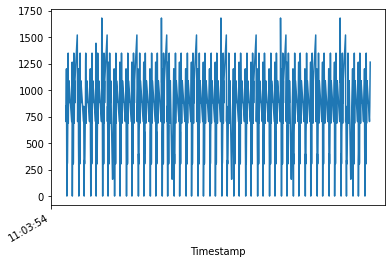

In [13]:
plot_features = df['ID'][0:1000]
plot_features.index = df_time[0:1000]
_ = plot_features.plot(subplots=True)

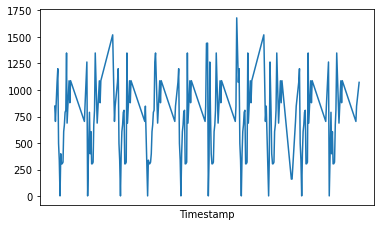

In [14]:
plot_features = df['ID'][0:200]
plot_features.index = df_time[0:200]
_ = plot_features.plot(subplots=True)

In [15]:
df_=df.drop(columns={'DLC', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'})

In [16]:
column_indices = {name: i for i, name in enumerate(df_.columns)}

n = len(df_)
train_df = df_[0:int(n*0.7)]
val_df = df_[int(n*0.7):int(n*0.9)]
test_df = df_[int(n*0.9):]

num_features = df_.shape[1]

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [18]:
w2 = WindowGenerator(input_width=200, label_width=1, shift=1,
                     label_columns=['ID'])
w2

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [200]
Label column name(s): ['ID']

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.asarray(train_df[:w2.total_window_size]),np.asarray(train_df[200:200+w2.total_window_size]),np.asarray(train_df[400:400+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 201, 2)
Inputs shape: (3, 200, 2)
Labels shape: (3, 1, 1)


In [21]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
val_performance = {}
performance = {}

In [24]:
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## CNN

In [49]:
CONV_WIDTH = 200
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ID'])

conv_window

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [200]
Label column name(s): ['ID']

In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [51]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [58]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


6174/6174 [==============================] - 23s 4ms/step - loss: 23126.8066 - mean_absolute_error: 80.5229


## RNN with GRU windows w/ window size 200

In [59]:
GRU_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [60]:
wide_window = WindowGenerator(
    input_width=200, label_width=200, shift=1,
    label_columns=['ID'])

wide_window

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33 

In [61]:
history = compile_and_fit(GRU_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = GRU_model.evaluate(wide_window.val)
performance['GRU'] = GRU_model.evaluate(wide_window.test, verbose=0)

6174/6174 [==============================] - 45s 7ms/step - loss: 77694.2422 - mean_absolute_error: 181.7979


## RNN with GRU windows w/ window size 100

In [25]:
GRU_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [26]:
wide_window = WindowGenerator(
    input_width=200, label_width=200, shift=1,
    label_columns=['ID'])

wide_window

Total window size: 201
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33 

In [27]:
history = compile_and_fit(GRU_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = GRU_model.evaluate(wide_window.val)
performance['GRU'] = GRU_model.evaluate(wide_window.test, verbose=0)

6174/6174 [==============================] - 46s 7ms/step - loss: 73359.0234 - mean_absolute_error: 179.8698
